## Classification

Let's now retrieve the classification embeddings from the chromadb vector database and perform classification on them.

In [48]:
import chromadb

client = chromadb.PersistentClient(path="./chroma_db")
collection = client.get_collection("nomic_classification_v1")

Now let us get the words along with their classes and division and sections from the json file we created earlier.

In [49]:
import json

with open("hierarchy.json", "r") as f:
    categories = json.load(f)

Let's retrieve the embeddings and the words along with the class, division, and section from the chromadb and create a dataframe with them.

In [50]:
import pandas as pd

# Retrieve the embeddings, words, and metadata
words = collection.get(include=["embeddings", "documents"])['documents']
embeddings = collection.get(include=["embeddings", "documents"])['embeddings']
metadata = collection.get(include=["embeddings", "documents", "metadatas"])['metadatas']

# Create a dataframe with the embeddings and the words
cls_df = pd.DataFrame({'word': words, 'embedding': embeddings})

# Add the class, division, and section from metadata to the dataframe
cls_df['class'] = [md['class'] for md in metadata]
cls_df['division'] = [md['division'] for md in metadata]
cls_df['section'] = [md['section'] for md in metadata]

cls_df

,word,embedding,class,division,section
0,Existence,"[-0.029754638671875, -0.0263671875, -0.0127792...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
1,Inexistence,"[-0.01029205322265625, 0.019256591796875, -0.0...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,EXISTENCE
2,Consanguinity,"[0.0386962890625, -0.01026153564453125, -0.013...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,RELATION
3,Trisection,"[0.007350921630859375, -0.001903533935546875, ...",WORDS EXPRESSING ABSTRACT RELATIONS,N/A,NUMBER
4,Innocence,"[0.0338134765625, 0.0139923095703125, -0.03097...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
...,...,...,...,...,...
1052,Knave,"[0.0032215118408203125, 0.01201629638671875, -...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1053,Disinterestedness,"[-0.01776123046875, 0.020965576171875, -0.0221...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1054,Selfishness,"[0.01071929931640625, 0.049468994140625, -0.03...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS
1055,Virtue,"[0.0201416015625, 0.006626129150390625, -0.035...",WORDS RELATING TO THE SENTIENT AND MORAL POWERS,N/A,MORAL AFFECTIONS


Now let's prepare the data for classification by converting the class, division, and section to numerical values.

In [51]:
# Make all classes and divisions/sections as numerical values
cls_df['class'] = pd.Categorical(cls_df['class'])
cls_df['division'] = pd.Categorical(cls_df['division'])
cls_df['section'] = pd.Categorical(cls_df['section'])

cls_df['class'] = cls_df['class'].cat.codes
cls_df['division'] = cls_df['division'].cat.codes
cls_df['section'] = cls_df['section'].cat.codes
cls_df

,word,embedding,class,division,section
0,Existence,"[-0.029754638671875, -0.0263671875, -0.0127792...",0,4,7
1,Inexistence,"[-0.01029205322265625, 0.019256591796875, -0.0...",0,4,7
2,Consanguinity,"[0.0386962890625, -0.01026153564453125, -0.013...",0,4,29
3,Trisection,"[0.007350921630859375, -0.001903533935546875, ...",0,4,19
4,Innocence,"[0.0338134765625, 0.0139923095703125, -0.03097...",4,4,16
...,...,...,...,...,...
1052,Knave,"[0.0032215118408203125, 0.01201629638671875, -...",4,4,16
1053,Disinterestedness,"[-0.01776123046875, 0.020965576171875, -0.0221...",4,4,16
1054,Selfishness,"[0.01071929931640625, 0.049468994140625, -0.03...",4,4,16
1055,Virtue,"[0.0201416015625, 0.006626129150390625, -0.035...",4,4,16


Let's also prepare the embeddings for classification by converting them to a numpy array.

In [52]:
import numpy as np

X = np.vstack(cls_df['embedding'])

### Multi-class logistic regression

Let us start by training a multi-class logistic regression model on the embeddings and the class.

Before we do that, however, let's split the data into training and testing sets, using 80% of the data for training and 20% for testing.

In [53]:
from sklearn.model_selection import train_test_split

y = cls_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now let's train a logistic regression model on the training data and evaluate it on the testing data.

In [9]:
# Train a logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   random_state=42)

In [54]:
from sklearn import metrics

# Generate classification report

y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

7/7 [==============================] - 0s 833us/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

Having trained and evaluated the model, we can see that the model has an accuracy of 0.64, 
which is not bad considering the previous results we got from the clustering of the embeddings.

However, let's use a hyperparameter tuning library such as `optuna` to find the best hyperparameters for the model.

We will use the `cross_val_score` function from `sklearn` to evaluate the model using cross-validation and the `optuna` library to find the best hyperparameters for the model based on the maximization of the accuracy.

In [11]:
from sklearn.model_selection import cross_val_score
import optuna


def objective(trial):
    # Define the hyperparameters to tune
    multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)

    # Create logistic regression model with suggested hyperparameters
    model = LogisticRegression(C=C, random_state=42, max_iter=1000, multi_class=multi_class, n_jobs=-1)
    # Perform cross-validation and return the mean score
    score = cross_val_score(model, X, y, scoring='accuracy')
    return score.mean()


# Create a study object and specify the optimization direction
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Output the best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2024-02-23 12:26:45,484] A new study created in memory with name: no-name-305a575b-7f01-493b-a017-e69eaec63beb
[I 2024-02-23 12:26:51,664] Trial 0 finished with value: 0.6023668639053255 and parameters: {'multi_class': 'ovr', 'C': 661.376255805555}. Best is trial 0 with value: 0.6023668639053255.
[I 2024-02-23 12:26:57,083] Trial 1 finished with value: 0.6378698224852071 and parameters: {'multi_class': 'multinomial', 'C': 6.385372774006955}. Best is trial 1 with value: 0.6378698224852071.
[I 2024-02-23 12:27:02,258] Trial 2 finished with value: 0.21183431952662723 and parameters: {'multi_class': 'multinomial', 'C': 0.0011120920175576884}. Best is trial 1 with value: 0.6378698224852071.
[I 2024-02-23 12:27:07,827] Trial 3 finished with value: 0.6366863905325444 and parameters: {'multi_class': 'multinomial', 'C': 18.9677376569383}. Best is trial 1 with value: 0.6378698224852071.
[I 2024-02-23 12:27:13,553] Trial 4 finished with value: 0.5917159763313611 and parameters: {'multi_class':

Best trial: {'multi_class': 'ovr', 'C': 8.038461586013085}


### Multi-class SVM

Let's now train a multi-class SVM model on the embeddings and the class.

In [75]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', random_state=22)
svm_model.fit(X_train, y_train)

SVC(random_state=22)

In [76]:
from sklearn import metrics

# Generate classification report
y_pred = svm_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70        44
           1       0.62      0.53      0.57        30
           2       0.71      0.48      0.58        31
           3       0.73      0.81      0.77        27
           4       0.62      0.77      0.69        31
           5       0.63      0.63      0.63        49

    accuracy                           0.66       212
   macro avg       0.67      0.66      0.66       212
weighted avg       0.66      0.66      0.66       212


Let's use the `optuna` library to find the best hyperparameters for the model based on the maximization of the accuracy.


In [70]:
def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # If kernel is 'poly', we also tune degree
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 1, 5)

    # Create and train the SVM model
    if kernel == 'poly':
        model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=42)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)

    score = cross_val_score(model, X, y, scoring='accuracy')
    return score.mean()


# Create a study object and specify the optimization direction
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Output the best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2024-02-23 15:00:44,770] A new study created in memory with name: no-name-e83effc6-f9ff-42c6-819a-7d7b2e053cbe
[I 2024-02-23 15:00:45,653] Trial 0 finished with value: 0.21570240543682373 and parameters: {'C': 0.6858905527983484, 'kernel': 'poly', 'gamma': 'auto', 'degree': 5}. Best is trial 0 with value: 0.21570240543682373.
[I 2024-02-23 15:00:46,416] Trial 1 finished with value: 0.21570240543682373 and parameters: {'C': 0.00029909714045756334, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.21570240543682373.
[I 2024-02-23 15:00:46,847] Trial 2 finished with value: 0.4219708486094966 and parameters: {'C': 401.6327806521961, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 2 with value: 0.4219708486094966.
[I 2024-02-23 15:00:47,779] Trial 3 finished with value: 0.21570240543682373 and parameters: {'C': 0.05489127315400744, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.4219708486094966.
[I 2024-02-23 15:00:48,560] Trial 4 finished with val

Best trial: {'C': 1.0744695722664126, 'kernel': 'sigmoid', 'gamma': 'scale'}


### Multi-class SGD

Let's now train a multi-class SGD model on the embeddings and the class.

In [66]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='squared_hinge', max_iter=1000, n_jobs=-1, random_state=42 , 
                          penalty='l2', alpha=2.6545371602330262e-06, 
                          learning_rate='adaptive', eta0=0.007698135990041223)
sgd_model.fit(X_train, y_train)

SGDClassifier(alpha=2.6545371602330262e-06, eta0=0.007698135990041223,
              learning_rate='adaptive', loss='squared_hinge', n_jobs=-1,
              random_state=42)

In [67]:
# Generate classification report
y_pred = sgd_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.70      0.67        44
           1       0.64      0.53      0.58        30
           2       0.67      0.58      0.62        31
           3       0.68      0.70      0.69        27
           4       0.65      0.77      0.71        31
           5       0.65      0.61      0.63        49

    accuracy                           0.65       212
   macro avg       0.65      0.65      0.65       212
weighted avg       0.65      0.65      0.65       212


Let's use the `optuna` library to find the best hyperparameters for the model based on the maximization of the accuracy.

In [57]:
import optuna
from sklearn.model_selection import cross_val_score


def objective(trial):
    # Hyperparameters to tune
    loss = trial.suggest_categorical('loss', ['hinge', 'log_loss', 'squared_hinge', 'perceptron'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_float('eta0', 1e-5, 1e-1, log=True)  # Only relevant for certain learning rates

    # Create and train the SGD Classifier
    model = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, learning_rate=learning_rate, eta0=eta0,
                          random_state=42)
    model.fit(X_train, y_train)

    # Perform cross-validation and return the mean score
    scores = cross_val_score(model, X_train, y_train, cv=5)  # cv=5 for 5-fold cross-validation
    return scores.mean()


# Create a study object and specify the optimization direction
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

# Best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2024-02-23 14:55:04,575] A new study created in memory with name: no-name-6d4cad58-8733-45af-90cf-fd4a9269c631
[I 2024-02-23 14:55:06,032] Trial 0 finished with value: 0.5372781065088759 and parameters: {'loss': 'perceptron', 'penalty': 'elasticnet', 'alpha': 0.0002843539275930434, 'learning_rate': 'optimal', 'eta0': 4.780347017456094e-05}. Best is trial 0 with value: 0.5372781065088759.
[I 2024-02-23 14:55:06,383] Trial 1 finished with value: 0.5195266272189348 and parameters: {'loss': 'perceptron', 'penalty': 'elasticnet', 'alpha': 0.002442571598507189, 'learning_rate': 'invscaling', 'eta0': 0.0020001568877933305}. Best is trial 0 with value: 0.5372781065088759.
[I 2024-02-23 14:55:06,995] Trial 2 finished with value: 0.16804733727810653 and parameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.00333383263276087, 'learning_rate': 'constant', 'eta0': 0.01355398656226266}. Best is trial 0 with value: 0.5372781065088759.
[I 2024-02-23 14:55:07,110] Trial 3 finished with value: 0.

Best trial: {'loss': 'squared_hinge', 'penalty': 'l2', 'alpha': 2.6545371602330262e-06, 'learning_rate': 'adaptive', 'eta0': 0.007698135990041223}


### Multi-class Naive Bayes

It is known that Naive Bayes is a simple and effective algorithm for classification for NLP tasks. 
Let's now train a multi-class Naive Bayes model on the embeddings and the class, to see how it performs.

In [68]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

# Generate classification report
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        44
           1       0.55      0.53      0.54        30
           2       0.58      0.45      0.51        31
           3       0.74      0.85      0.79        27
           4       0.51      0.61      0.56        31
           5       0.61      0.61      0.61        49

    accuracy                           0.63       212
   macro avg       0.62      0.63      0.62       212
weighted avg       0.63      0.63      0.63       212


We can see that the Naive Bayes model has an accuracy of 0.63, which does not differ much from the logistic regression model.
So there is no need to use `optuna` to find the best hyperparameters for the model.

### Multi-class Random Forest

Let's now train a multi-class Random Forest model on the embeddings and the class.

In [58]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=15,
                               max_depth=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt')
model.fit(X_train, y_train)

# Generate classification report
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.66      0.67        44
           1       0.61      0.47      0.53        30
           2       0.86      0.39      0.53        31
           3       0.77      0.63      0.69        27
           4       0.56      0.77      0.65        31
           5       0.52      0.71      0.60        49

    accuracy                           0.62       212
   macro avg       0.67      0.61      0.61       212
weighted avg       0.65      0.62      0.61       212


### Multi-class CatBoost

Having tried the above models, let us now proceed to more advanced models such as CatBoost, 
which is a gradient boosting library that is known to perform well on tabular data, to see how it performs 
and if it can outperform the other models.

In [65]:
import catboost as cb

model = cb.CatBoostClassifier(iterations=500, task_type='GPU')
model.fit(X_train, y_train)
# Generate classification report
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

Learning rate set to 0.134538
0:	learn: 1.7228745	total: 25.9ms	remaining: 10.3s
1:	learn: 1.6604869	total: 47.1ms	remaining: 9.37s
2:	learn: 1.6080402	total: 68.8ms	remaining: 9.11s
3:	learn: 1.5585689	total: 89.7ms	remaining: 8.88s
4:	learn: 1.5091478	total: 110ms	remaining: 8.72s
5:	learn: 1.4662697	total: 131ms	remaining: 8.62s
6:	learn: 1.4287979	total: 152ms	remaining: 8.52s
7:	learn: 1.3910584	total: 173ms	remaining: 8.46s
8:	learn: 1.3552419	total: 194ms	remaining: 8.41s
9:	learn: 1.3165946	total: 214ms	remaining: 8.36s
10:	learn: 1.2851901	total: 235ms	remaining: 8.32s
11:	learn: 1.2504925	total: 257ms	remaining: 8.31s
12:	learn: 1.2190597	total: 279ms	remaining: 8.31s
13:	learn: 1.1924688	total: 301ms	remaining: 8.29s
14:	learn: 1.1640413	total: 323ms	remaining: 8.3s
15:	learn: 1.1362085	total: 346ms	remaining: 8.29s
16:	learn: 1.1100424	total: 367ms	remaining: 8.27s
17:	learn: 1.0878752	total: 388ms	remaining: 8.22s
18:	learn: 1.0624523	total: 408ms	remaining: 8.19s
19:	lear

Very interesting to note is that the Catboost model gave the lowest accuracy of 0.62,
which is lower than the other models we have tried so far, 
meaning that the more complex models do not always outperform the simpler ones.

### Neural Network

While neural networks need a lot of data to perform well, let's try a simple neural network model to see how it performs.

We will use the `keras` library to build the neural network model.

Let's start by making the train and test splits from above into TensorFlow datasets.

We will also define a validation dataset from the training data to monitor the model's performance during training.

In [7]:
import tensorflow as tf

# Parameters
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 600  # Adjust based on your dataset size
VALIDATION_SPLIT = 0.2  # Fraction of training data to use for validation

# Calculate the number of validation samples
n_validation_samples = int(len(X_train) * VALIDATION_SPLIT)

# Create and process the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_train[:n_validation_samples], y_train[:n_validation_samples]))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Update the training dataset to exclude the validation data and process it
train_ds = tf.data.Dataset.from_tensor_slices((X_train[n_validation_samples:], y_train[n_validation_samples:]))
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create and process the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

With that done, let's have a look at the first batch of the training dataset.

In [30]:
for feat, targ in train_ds.take(1):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: [[ 0.02937317  0.0199585  -0.02301025 ...  0.00671005 -0.05300903
  -0.0269928 ]
 [-0.02384949  0.0174408  -0.02377319 ...  0.02064514 -0.04141235
  -0.02015686]
 [ 0.03381348  0.01399231 -0.03097534 ... -0.01398468 -0.03561401
  -0.03076172]
 ...
 [-0.0461731   0.00856018 -0.01756287 ...  0.00897217 -0.03820801
   0.00946045]
 [-0.00187016  0.01035309 -0.02903748 ...  0.01985168 -0.0581665
  -0.02468872]
 [ 0.00093603 -0.0096817  -0.02001953 ...  0.02749634 -0.06008911
  -0.02041626]], Target: [4 4 4 2 3 0 0 3 3 2 3 1 2 3 5 4 4 5 2 5 5 0 0 5 5 2 1 3 3 0 4 4]


We can see that the training dataset is structured as expected, with the features and the targets batched together with a size of 32.

Now let's define an early stopping callback to stop training the model when the validation loss does not improve after a certain number of epochs. 

In [8]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=30,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

Another useful callback method in TensorFlow is the ModelCheckpoint callback. This callback saves the model at regular intervals during training, allowing you to retain and load the best version of your model based on a certain monitored metric, such as validation loss or accuracy.

In [9]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_{epoch:02d}-{val_loss:.2f}.keras',  # Change the extension to '.keras'
    save_weights_only=False,  # Set to True to save only weights, False to save the entire model
    monitor='val_loss',       # Monitor the validation loss
    mode='min',               # The model is saved when the monitored metric stops decreasing
    save_best_only=True,      # Only the best model is saved
    verbose=1                 # Verbosity mode, 1 or 0
)

CALLBACKS = [
    tfdocs.modeling.EpochDots(),
    early_stopping_callback,
    model_checkpoint_callback
]

Lastly, let's define a scheduler callback to adjust the learning rate during training.

In [10]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=1e-3,  # Initial learning rate
    decay_steps=STEPS_PER_EPOCH * 1000,  # Decay steps
    decay_rate=0.9,  # Decay rate
    staircase=True  # If True, decay the learning rate at discrete intervals
)

With all the callbacks and the learning rate scheduler defined, let's now build the neural network model.

We will use a simple neural network with two hidden layers, each with 64 units, and a ReLU activation function.

Also, we will use the Adam optimizer and the SparseCategoricalCrossentropy loss function, as well as the accuracy metric.

Lastly, we will add WeightRegularization to the model as well as DropoutLayers to prevent overfitting.

In [23]:
# Import keras 
from tensorflow.keras import layers
import keras
from keras import regularizers

weight_regularizer = regularizers.l2(0.0001)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],) , kernel_regularizer=weight_regularizer),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu' , kernel_regularizer=weight_regularizer),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu' , kernel_regularizer=weight_regularizer),
    layers.Dense(6, activation='softmax')
])

With the model created, let's compile it using the Adam optimizer, the SparseCategoricalCrossentropy loss function, and the accuracy metric.

In [24]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=(['accuracy',
                        tf.keras.losses.SparseCategoricalCrossentropy(
                            from_logits=False, name='sparse_categorical_crossentropy')]))

Let's see now the model summary

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                49216     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 6)                 102       
                                                                 
Total params: 51926 (202.84 KB)
Trainable params: 5192

We can see that the model has 51926 parameters to train, which are quite a lot for the small dataset we have.
However, with the Dropout layers and the WeightRegularization, we hope to prevent excessive overfitting.

Let's now train the model using the training dataset and the validation dataset we created earlier.

In [26]:
history = model.fit(train_ds, epochs=100, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=CALLBACKS)

Epoch 1/100
 1/22 [>.............................] - ETA: 9s - loss: 1.8088 - accuracy: 0.0938 - sparse_categorical_crossentropy: 1.7907
Epoch: 0, accuracy:0.1479,  loss:1.8079,  sparse_categorical_crossentropy:1.7929,  val_accuracy:0.1361,  val_loss:1.8075,  val_sparse_categorical_crossentropy:1.7901,  
.
Epoch 1: val_loss did not improve from 1.18581
22/22 [==============================] - 1s 5ms/step - loss: 1.8079 - accuracy: 0.1479 - sparse_categorical_crossentropy: 1.7929 - val_loss: 1.8075 - val_accuracy: 0.1361 - val_sparse_categorical_crossentropy: 1.7901
Epoch 2/100
 1/22 [>.............................] - ETA: 0s - loss: 1.8057 - accuracy: 0.1250 - sparse_categorical_crossentropy: 1.7887.
Epoch 2: val_loss did not improve from 1.18581
22/22 [==============================] - 0s 2ms/step - loss: 1.8013 - accuracy: 0.2071 - sparse_categorical_crossentropy: 1.7831 - val_loss: 1.8008 - val_accuracy: 0.1716 - val_sparse_categorical_crossentropy: 1.7805
Epoch 3/100
 1/22 [>......

Now using tfdocs.plots.HistoryPlotter, we can visualize the training and validation loss and accuracy.

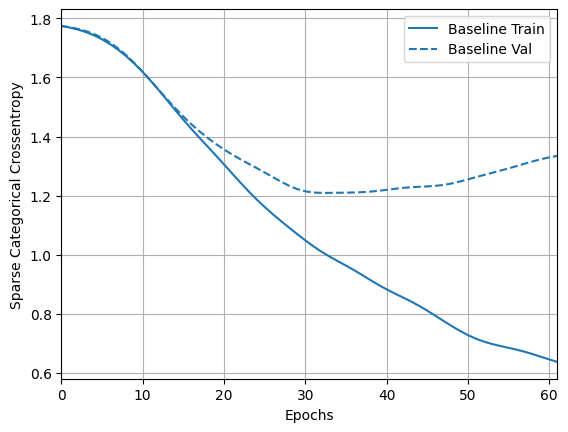

In [27]:
size_histories = {}
size_histories['Baseline'] = history
plotter = tfdocs.plots.HistoryPlotter(metric = 'sparse_categorical_crossentropy', smoothing_std=10)
plotter.plot(size_histories)

We can see that the model the validation loss becomes stagnant after 30 epochs.

Let's now evaluate the model on the test dataset.

In [28]:
model.evaluate(test_ds, verbose=1, batch_size=BATCH_SIZE)

7/7 [==============================] - 0s 833us/step - loss: 1.1549 - accuracy: 0.6132 - sparse_categorical_crossentropy: 1.1164


[1.1548932790756226, 0.6132075190544128, 1.1164045333862305]

Let's also generate a classification report for the model.

In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 667us/step
              precision    recall  f1-score   support

           0       0.52      0.77      0.62        44
           1       0.57      0.70      0.63        30
           2       0.70      0.45      0.55        31
           3       0.74      0.63      0.68        27
           4       0.59      0.61      0.60        31
           5       0.71      0.51      0.60        49

    accuracy                           0.61       212
   macro avg       0.64      0.61      0.61       212
weighted avg       0.64      0.61      0.61       212


We can see that the model has an accuracy of 0.61, which is not bad considering the small dataset we have.

However, we can see that the model is overfitting the training data, as the validation loss becomes higher than the training loss quickly,
which makes sense given the small dataset we have.

Ironically, the simpler models such as logistic regression and SGD outperformed the neural network model.

### Two-Level Classification

As we saw from before, we got the best results using the SGD Classifier.

Let's now try to perform a two-level classification, where we first classify the class of the word and then classify the division/section of the word based on the class it belongs to.